In [1]:
# Error analysis

# Read in libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

In [95]:
errordata = pd.read_csv('https://raw.githubusercontent.com/tmarchok1/DS440_project/refs/heads/Travis/errordata.csv')
errordata.head()

newerrordata = errordata.drop(errordata.columns[:120], axis=1)
newerrordata

,year_x,day_of_week_x,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,year_y,day_of_week_y,week,h_name,v_name,park_id,actual,predicted,residual,absresidual
0,2005,Sun,1,1,56937.0,101,1,1,3900000,19940274,2005,Sun,1,NYY,BOS,Old Yankee Stadium,54818.0,53305.445771,1512.554229,1512.554229
1,2005,Mon,0,0,45971.0,78,0,0,746000,2859024,2005,Mon,1,BAL,OAK,Camden Yards,48271.0,38851.046433,9419.953567,9419.953567
2,2005,Mon,0,0,40615.0,83,0,0,664000,9408576,2005,Mon,1,CHW,CLE,US Cellular Field,38141.0,28430.869302,9710.130698,9710.130698
3,2005,Mon,0,0,41083.0,72,0,0,1000000,4400587,2005,Mon,1,DET,KC,Comerica Park,44105.0,17843.517213,26261.482787,26261.482787
4,2005,Mon,0,1,47943.0,63,0,0,927000,4145494,2005,Mon,1,SEA,MIN,Safeco Field,46249.0,35862.823685,10386.176315,10386.176315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21771,2013,Sun,0,1,36742.0,69,0,0,783000,6457988,2013,Sun,24,MIA,DET,Marlins Park,28315.0,25541.019100,2773.980900,2773.980900
21772,2013,Sun,0,0,41922.0,74,0,0,1700000,19940274,2013,Sun,24,NYM,MIL,Citi Field,41891.0,32999.632505,8891.367495,8891.367495
21773,2013,Sun,0,0,41915.0,94,1,1,1600000,4648486,2013,Sun,24,SF,SD,AT&T Park,41495.0,41662.148729,-167.148729,167.148729
21774,2013,Sun,0,1,45494.0,88,1,0,1100000,2811927,2013,Sun,24,STL,CHC,Busch Stadium III,44808.0,44432.662060,375.337940,375.337940


<Axes: xlabel='week'>

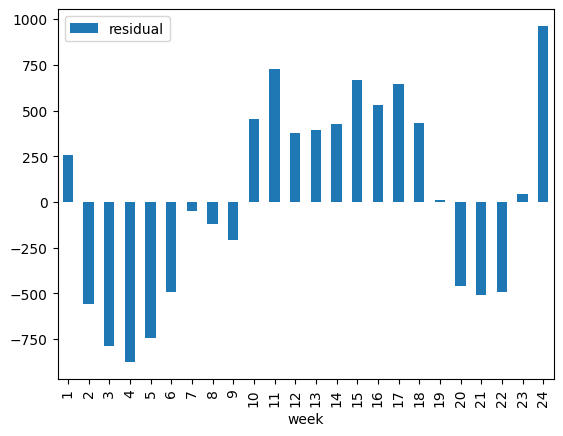

In [81]:
# Examine residuals throughout the weeks of each season
resids = errordata.groupby('week')['residual'].mean().to_frame()
resids.plot(kind='bar', y='residual')

<Axes: xlabel='h_name'>

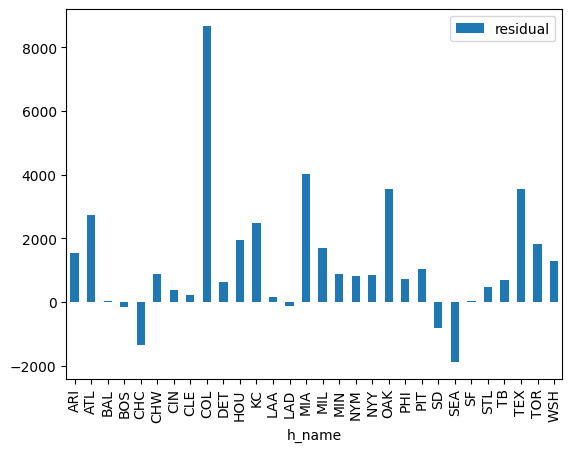

In [86]:
# Rockies have high residuals in week 24, and almost all teams are being underestimated
resids = errordata[errordata['week'] == 24].groupby('h_name')['residual'].mean().to_frame()
resids.plot(kind='bar', y='residual')

<Axes: xlabel='day_of_week_x'>

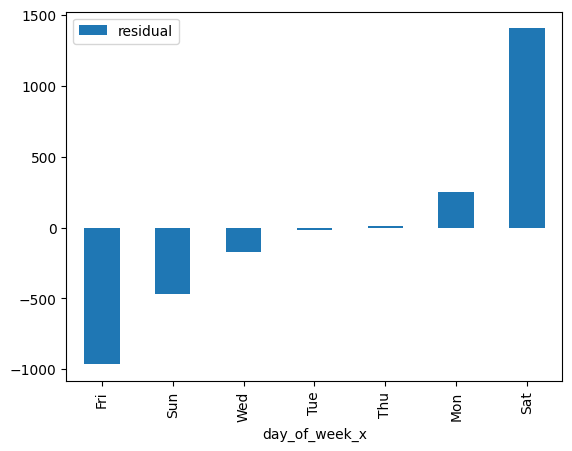

In [67]:
resids = errordata.groupby('day_of_week_x')['residual'].mean().sort_values().to_frame()
resids.plot(kind='bar', y='residual')

<Axes: xlabel='h_name'>

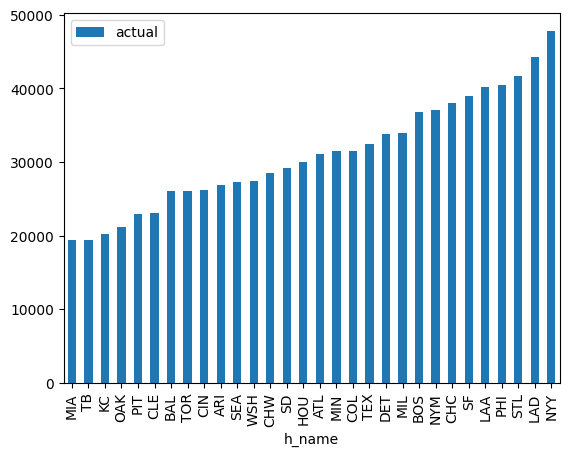

In [75]:
resids = errordata.groupby('h_name')['actual'].mean().sort_values().to_frame()
resids.plot(kind='bar', y='actual')

In [75]:
# Compute residuals
residuals = errordata.groupby('h_name').apply(lambda group: pd.Series({
        'overest': (group['residual'] < 0).sum(),
        'underest': (group['residual'] > 0).sum()
    })
).reset_index()
residuals['percent_overest'] = residuals['overest'] / (residuals['underest'] +residuals['overest'])
residuals = residuals.sort_values(by='percent_overest', ascending=False)

residuals

C:\Users\travi\AppData\Local\Temp\ipykernel_37700\1304938153.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  residuals = errordata.groupby('h_name').apply(lambda group: pd.Series({


,h_name,overest,underest,percent_overest
0,ARI,425,304,0.582990
11,KC,418,303,0.579750
7,CLE,418,305,0.578147
19,OAK,418,306,0.577348
22,SD,419,310,0.574760
28,TOR,415,314,0.569273
26,TB,407,316,0.562932
8,COL,409,318,0.562586
23,SEA,406,323,0.556927
14,MIA,400,320,0.555556


<Axes: xlabel='actual', ylabel='absresidual'>

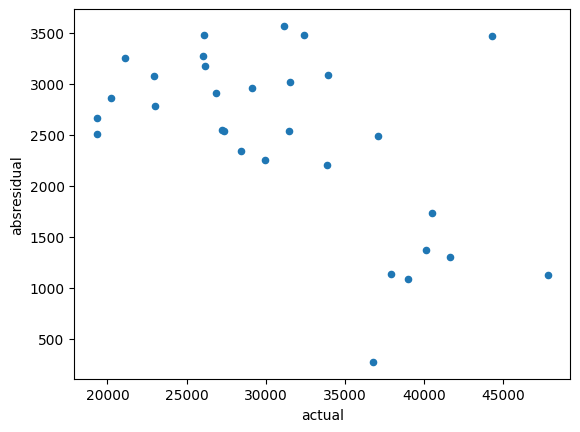

In [63]:
avg_att_resid = newerrordata.groupby('h_name').agg(
    {'actual': 'mean',
    'absresidual': 'mean'}
)

# Standardize each team's average residual
#avg_att_resid['std'] = avg_att_resid['absresidual']/avg_att_resid['actual']

avg_att_resid
avg_att_resid.plot(kind='scatter', x='actual', y='absresidual')